In [2]:
#Import Libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import shap



/home/aa2956/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#Read training data and data to test model against, both into a dataframe
data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')


In [4]:
#Remove the sale price from the training data frame and place it into a seperate data frame. Use x and y to train the model.
x = data.drop(['SalePrice'],axis=1)
y = data['SalePrice']

In [5]:
#I removed non scalar features such as 'Alley' and 'Fence'. Although they are important, I could not find a way to get them to work with xgboost
# and the model still performs good enough using just the numerical features, hence, I only used the 37 numerical features instead of all 80. I did the same for the test data as well. 

x = x.select_dtypes(include = ['float64', 'int64'])
x_test = test_data.select_dtypes(include= ['float64', 'int64'])


In [6]:
#I created the model using XGBoost, I gave it a smaller learning rate, set the loss function to mean square log error
bestFit=xgb.XGBRegressor(learning_rate = 0.01,
                           eval_metric='rmsle')
#I trained the model using the numerical features from train.csv and the house sale prices also from train.csv. 
bestFit.fit(x,y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmsle', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [7]:
#I gave the now trained model the new test data which it has not seen before.
predictTestData = bestFit.predict(x_test)


In [8]:
#I found the real correct sale prices online on kaggle. I read those into a data frame
solution  = pd.read_csv('solution.csv')
y_true     = solution["SalePrice"]
#I compared the prediction that the model came up with against the correct solution to see how it fared
#I used the MSLE to check how the model performed
from sklearn.metrics import mean_squared_log_error
error = np.sqrt( mean_squared_log_error(y_true, predictTestData) )
print("The score is " % error )

The score is 0.14296


In [9]:
shap.initjs()

In [10]:
#I took a random sample of the input houses because getting shap values for all of them would be very resource intensive
#since the xgb uses a gb tree, I used the shap tree explainer and gave it the xgb model as a parameter
X_sampled = x.sample(100, random_state=10)
explainer = shap.TreeExplainer(bestFit)
shap_values = explainer.shap_values(X_sampled)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [11]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_sampled.iloc[0,:])
#this plot shows the impact of each invidividual feature
#The next two plots also show the metrics of each feature

In [12]:
shap.force_plot(explainer.expected_value, shap_values, x)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


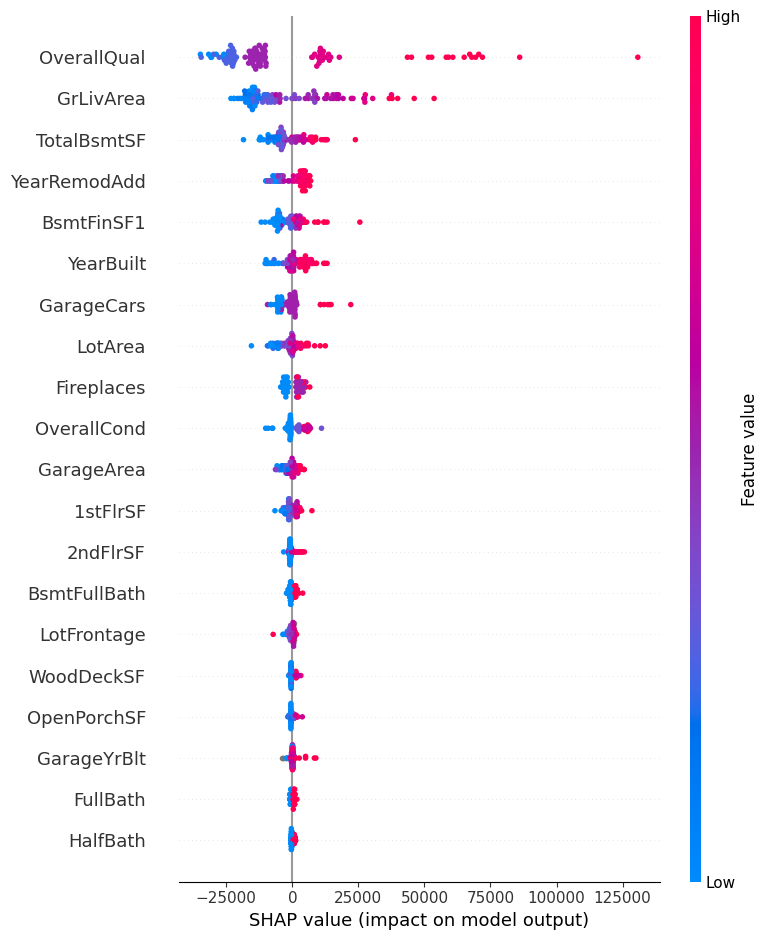

In [13]:
shap.summary_plot(shap_values, X_sampled)

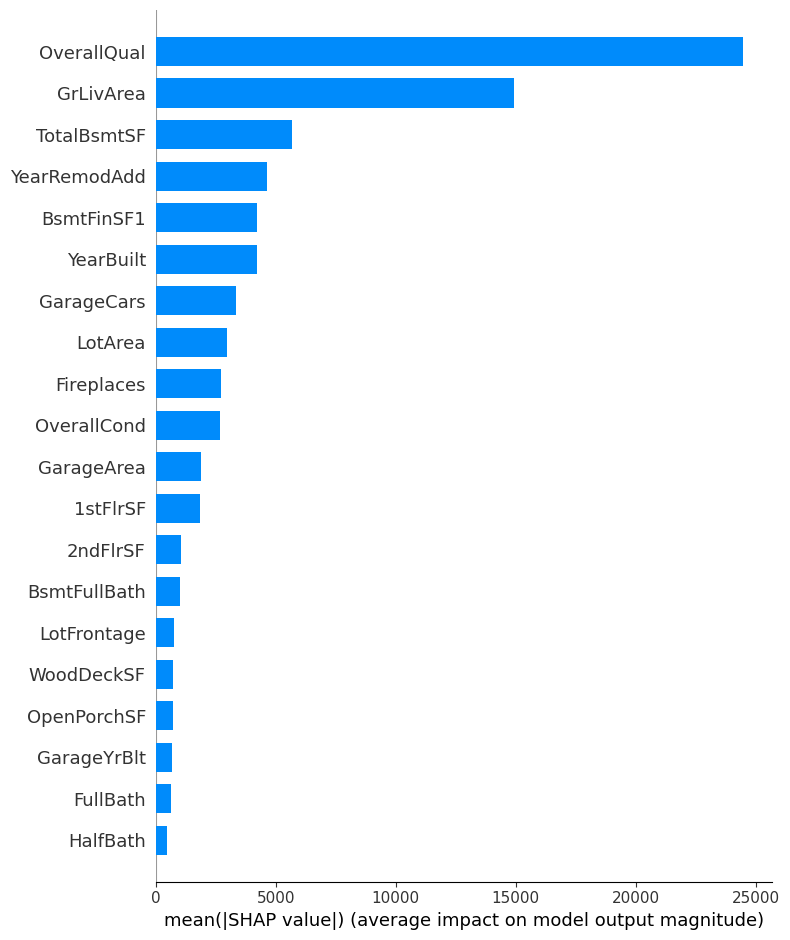

In [14]:
shap.summary_plot(shap_values, x, plot_type="bar")

In [15]:
shap_interaction_values = explainer.shap_interaction_values(X_sampled)


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


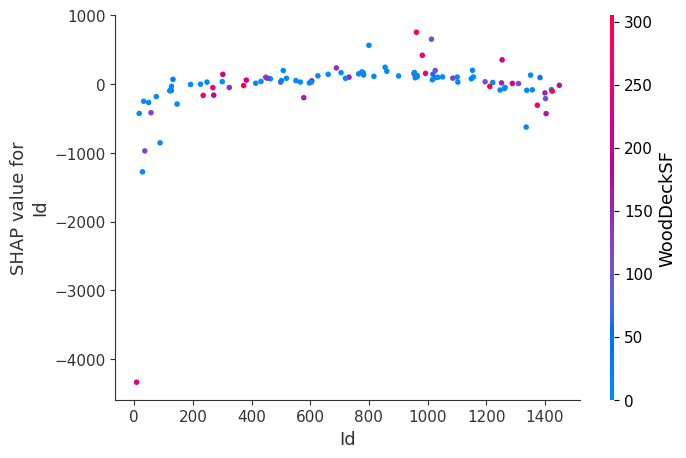

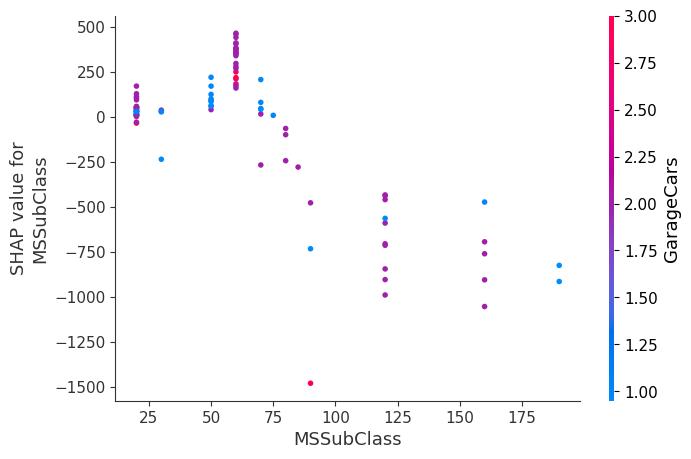

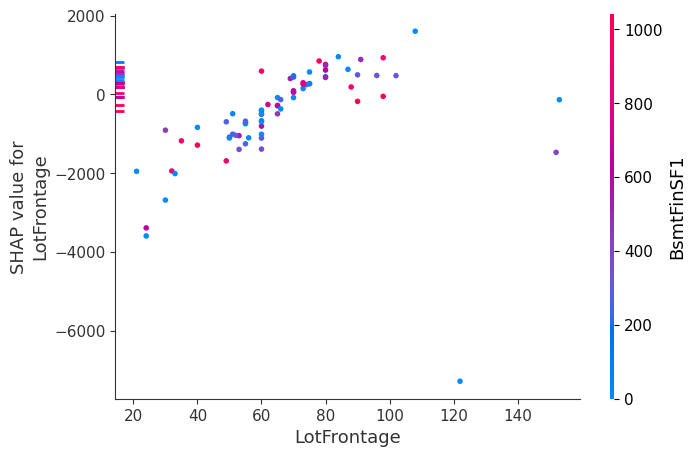

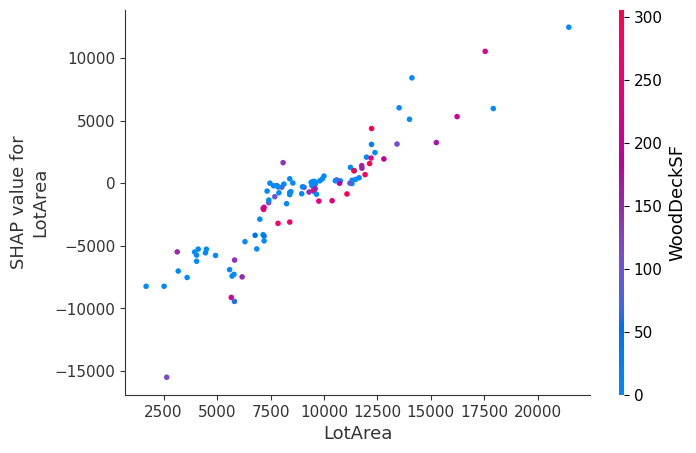

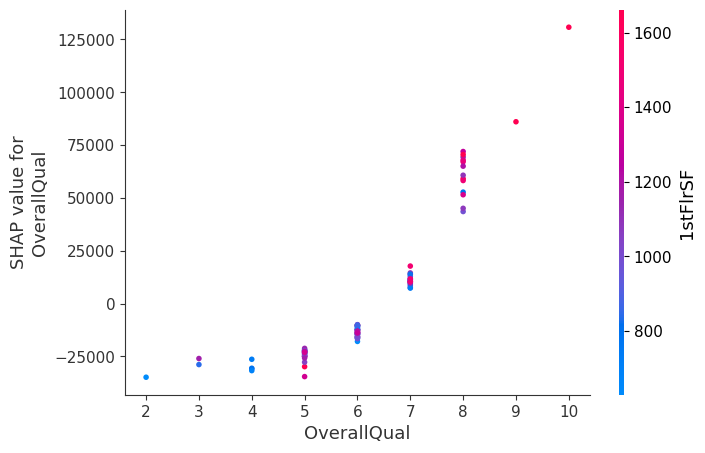

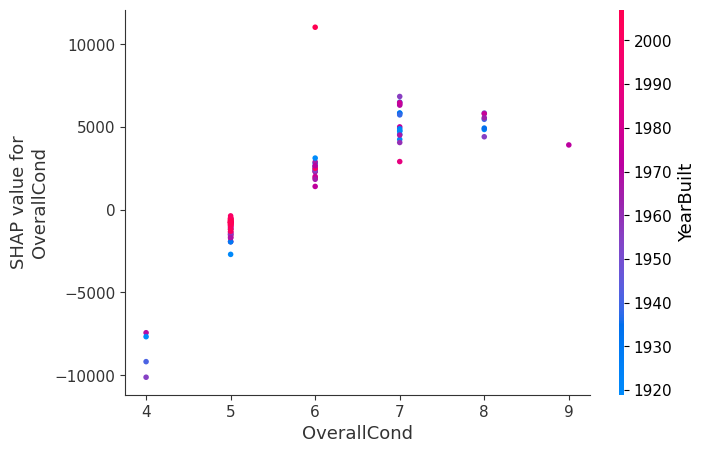

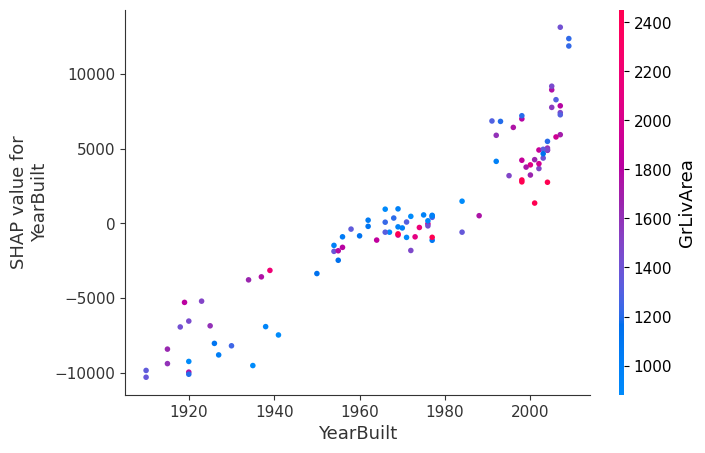

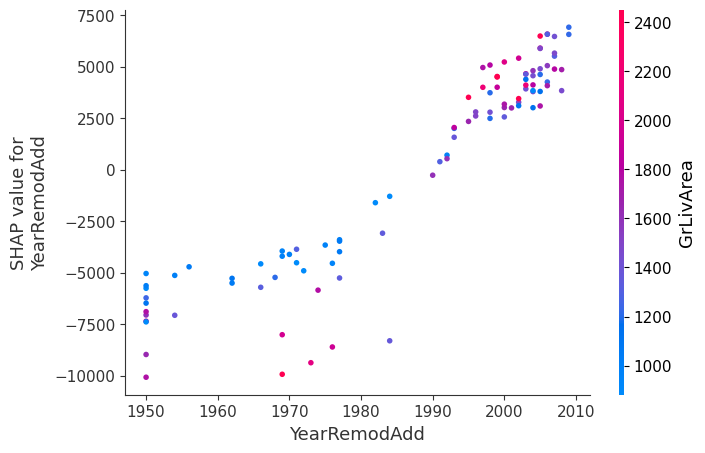

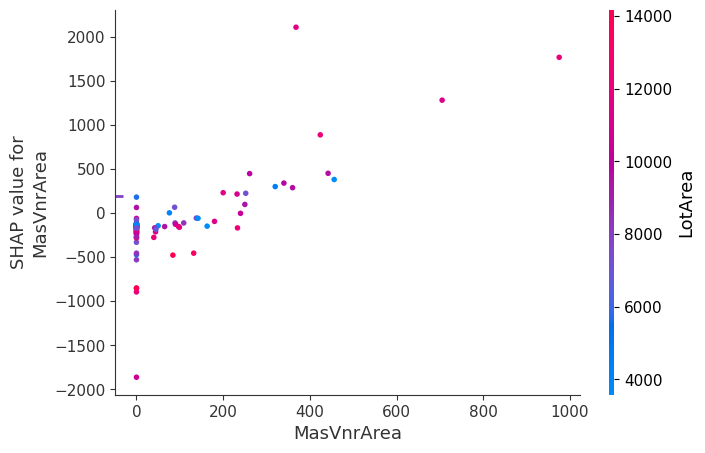

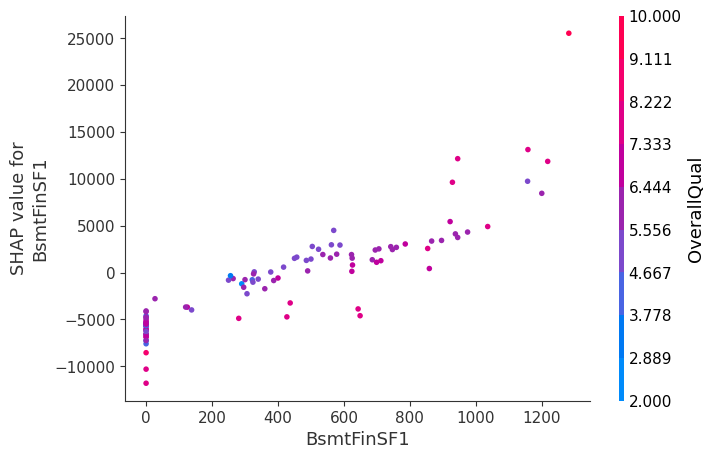

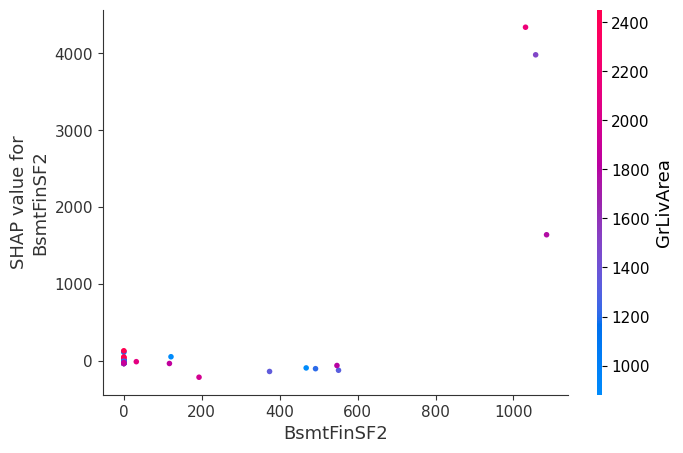

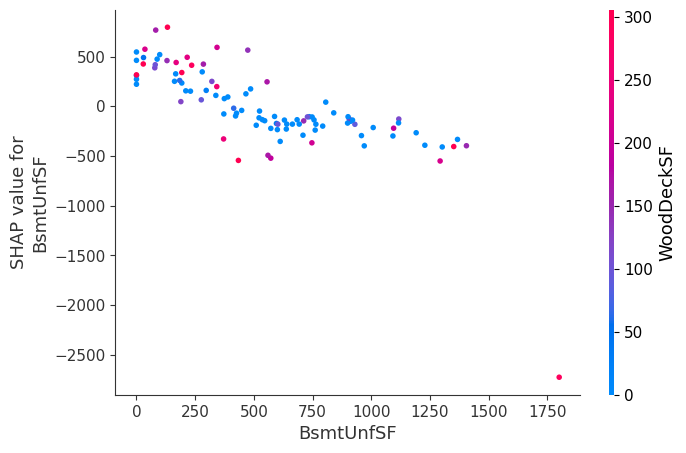

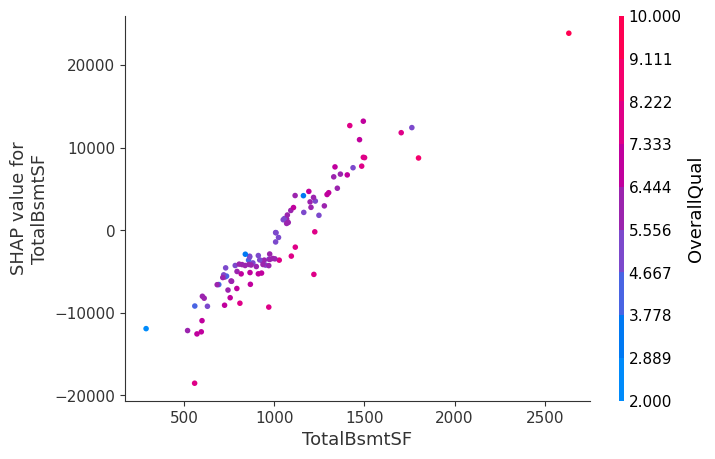

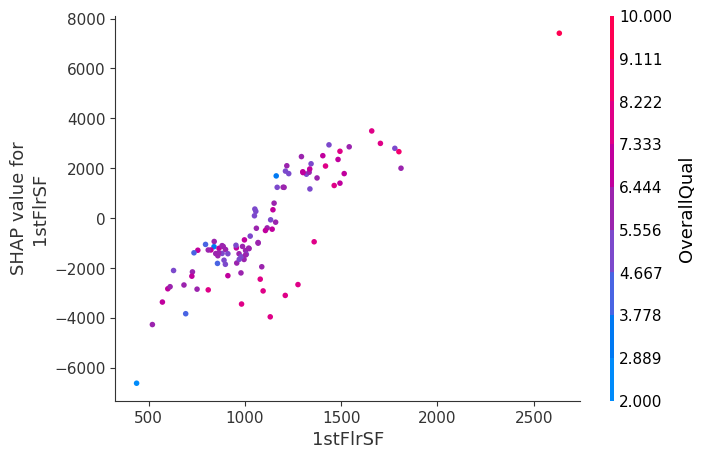

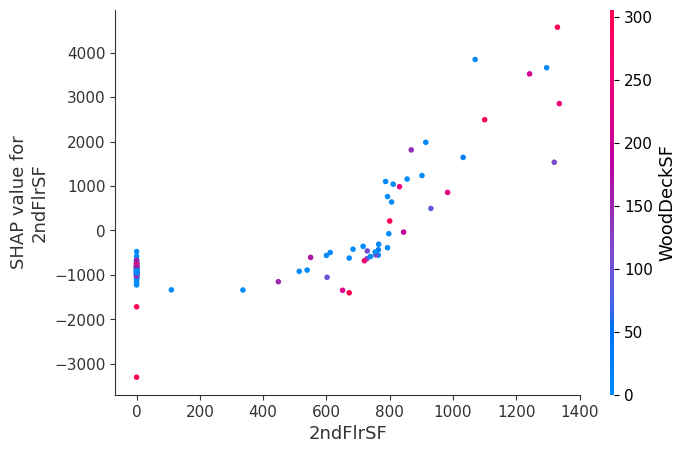

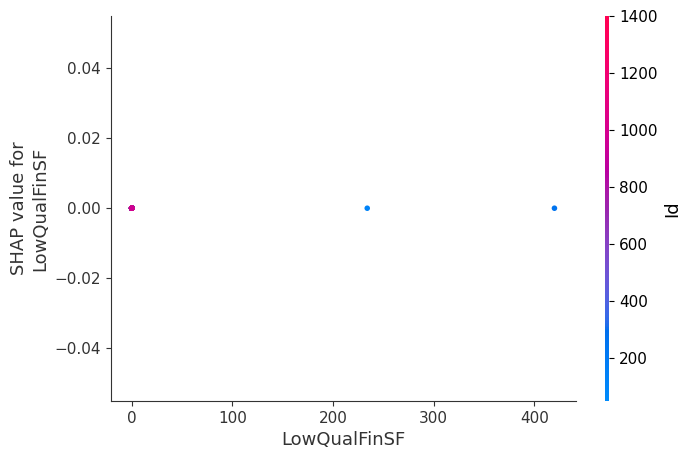

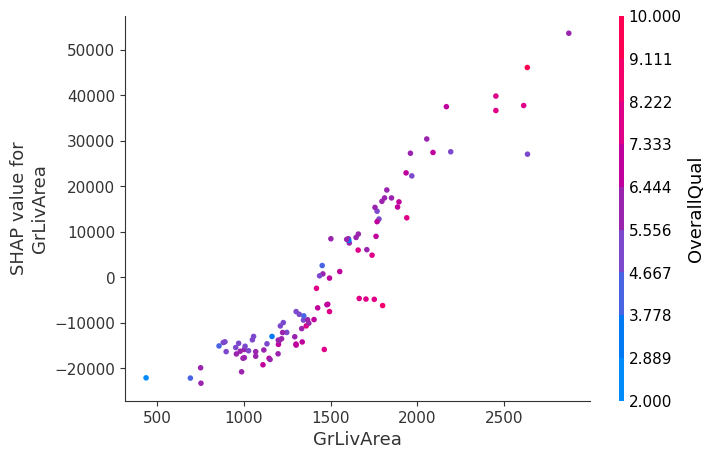

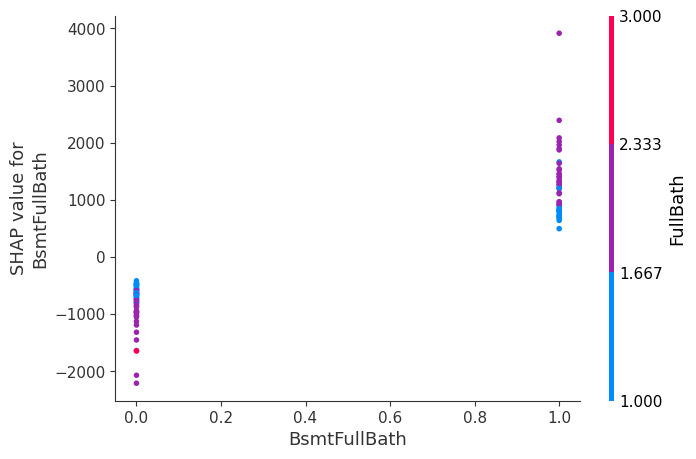

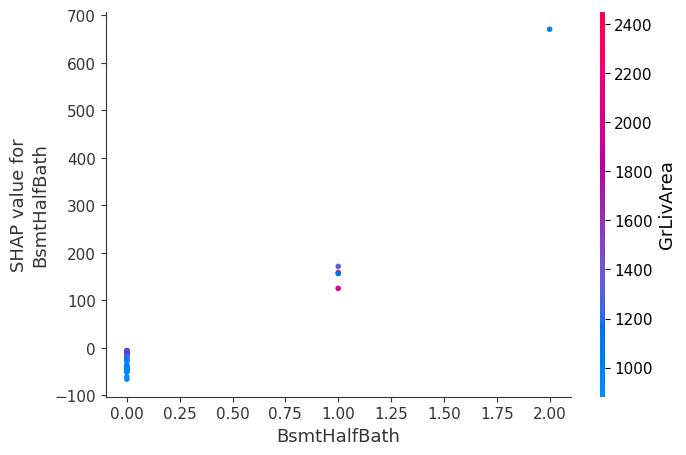

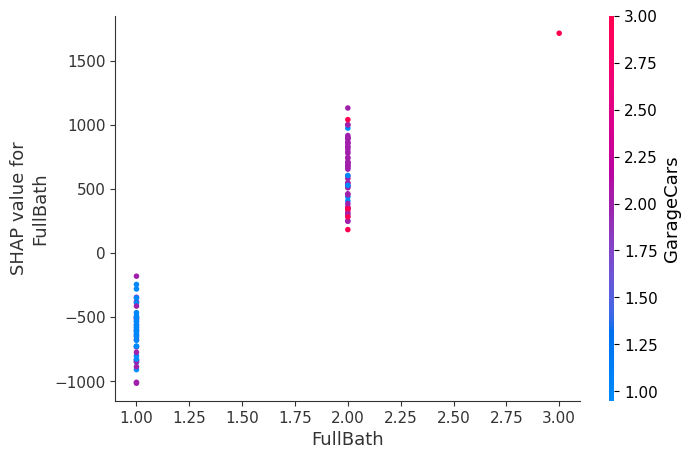

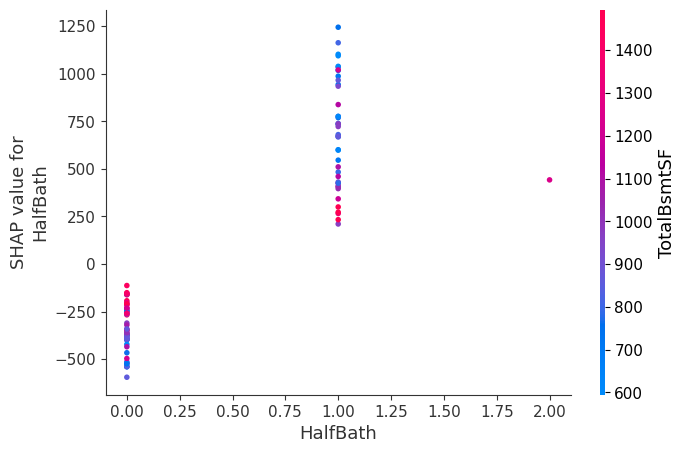

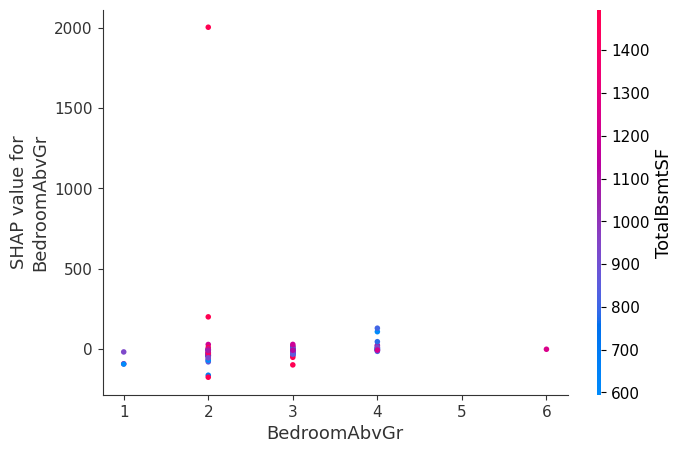

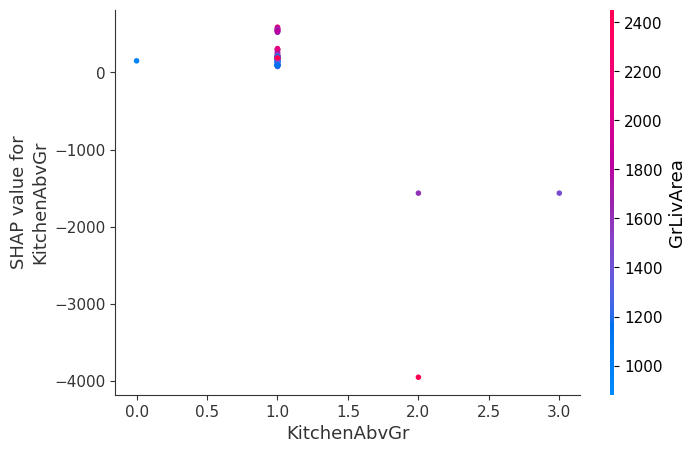

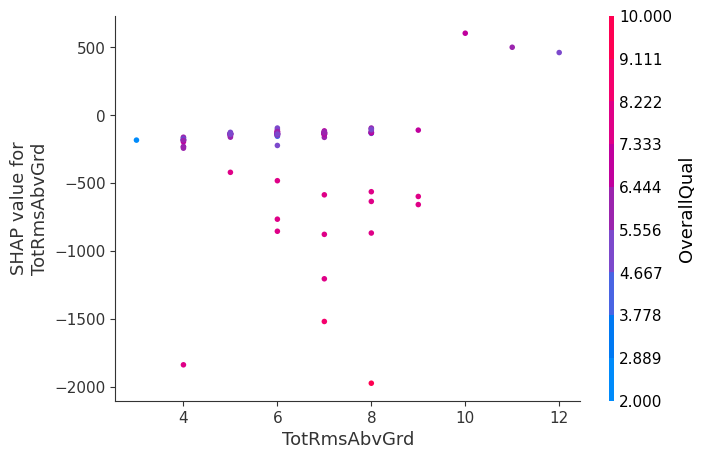

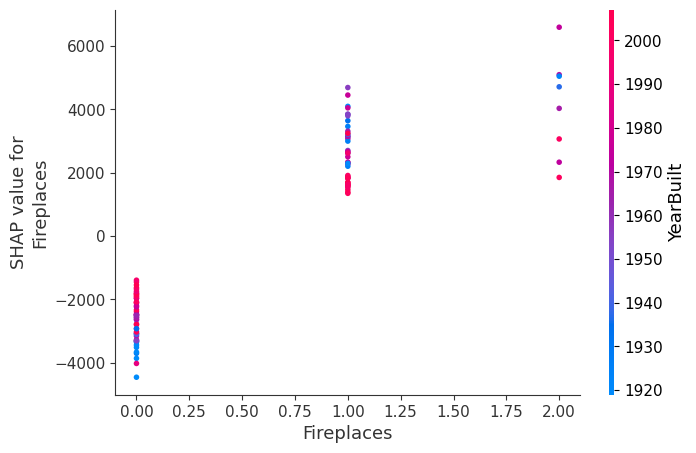

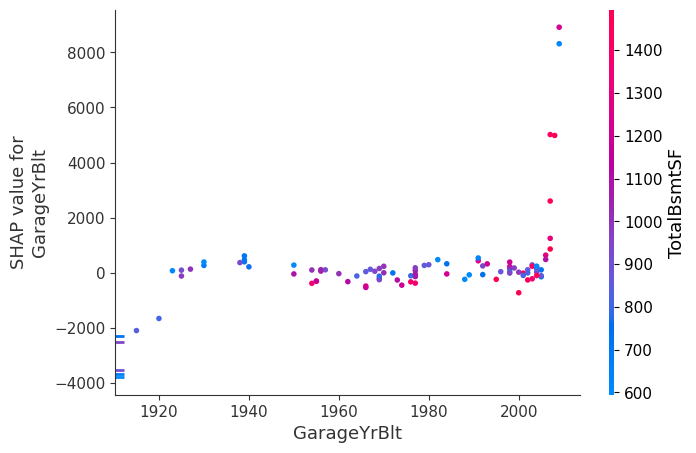

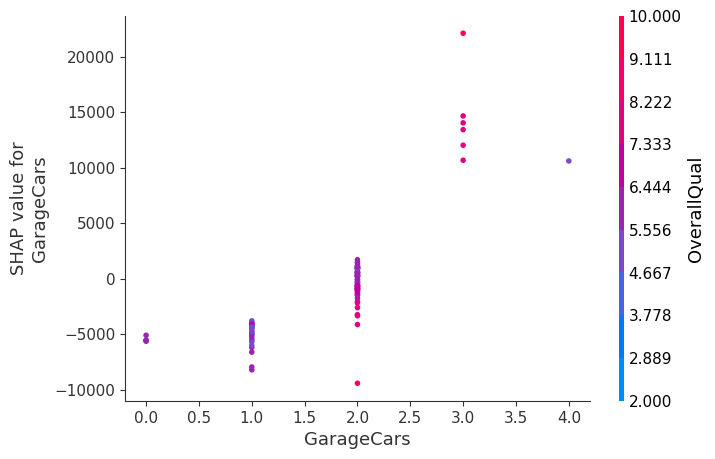

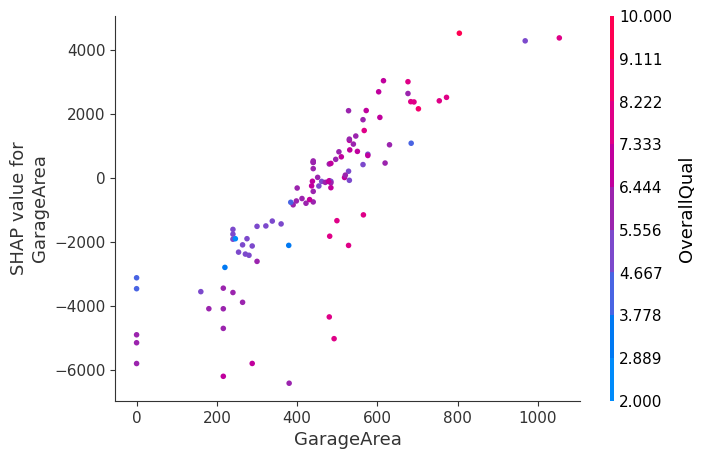

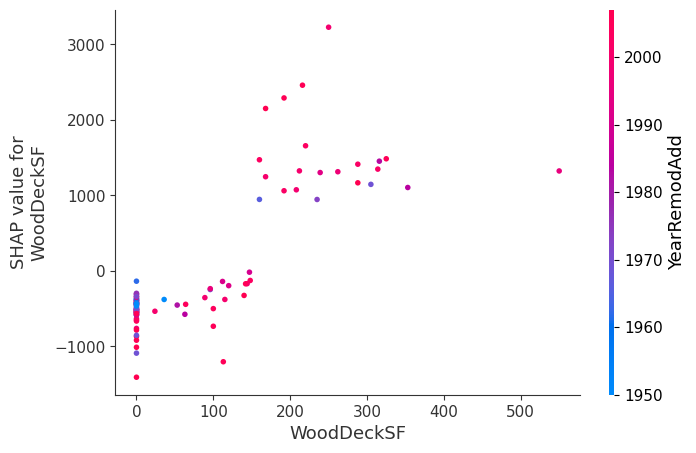

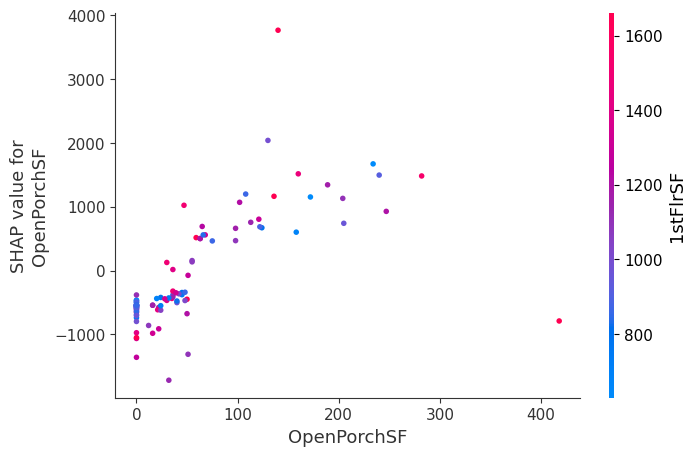

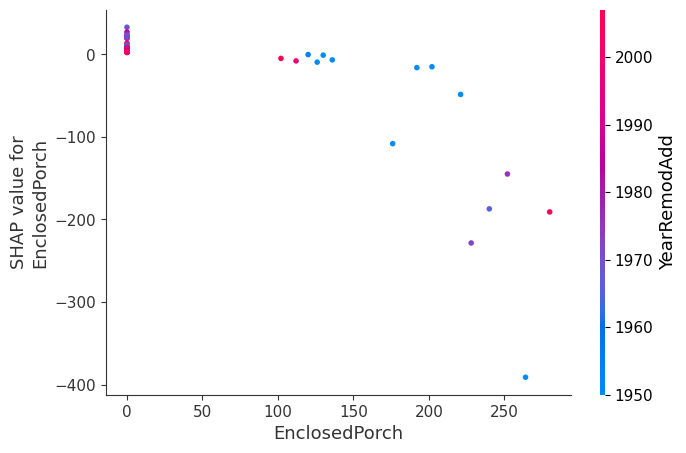

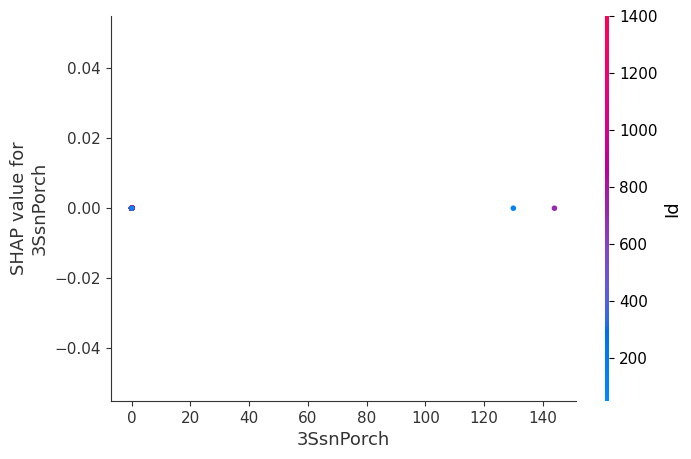

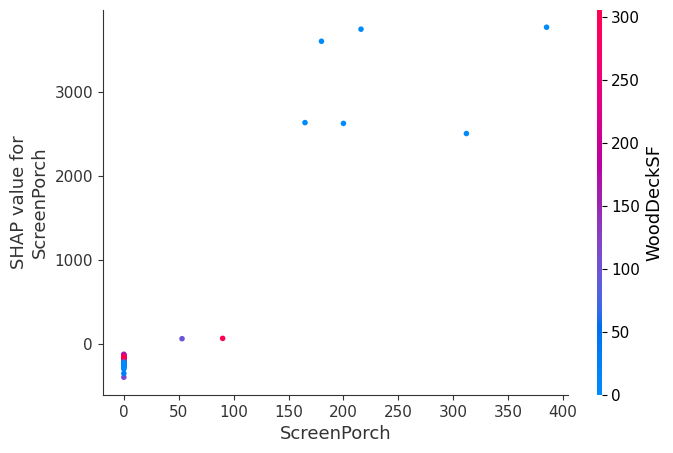

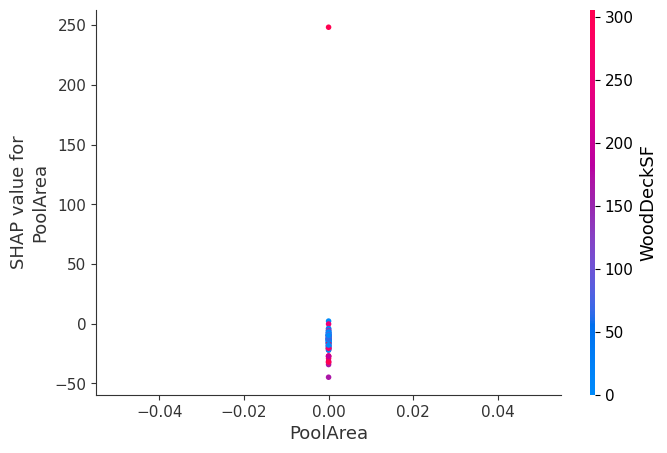

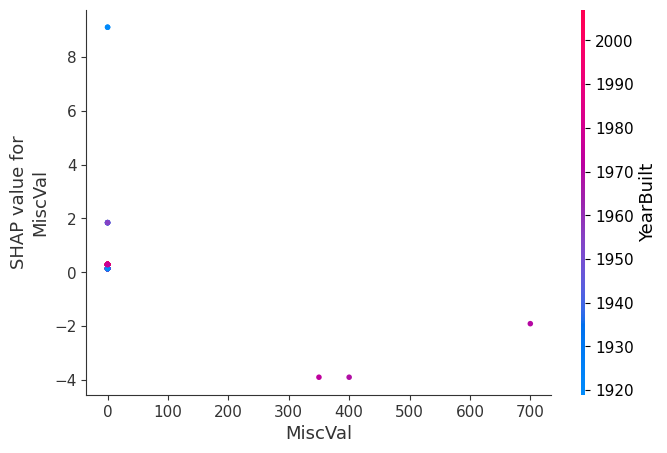

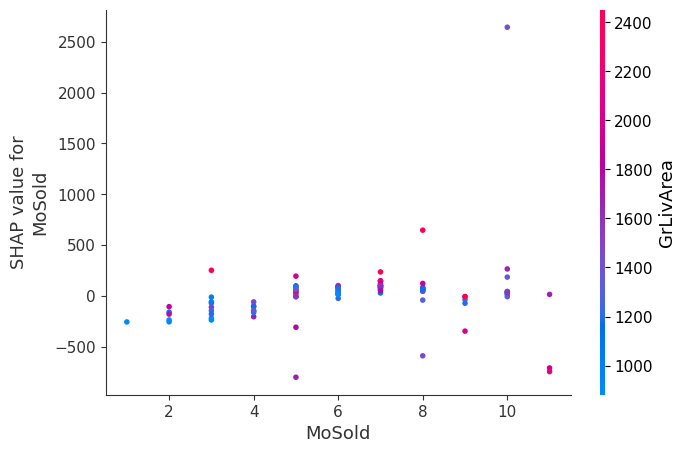

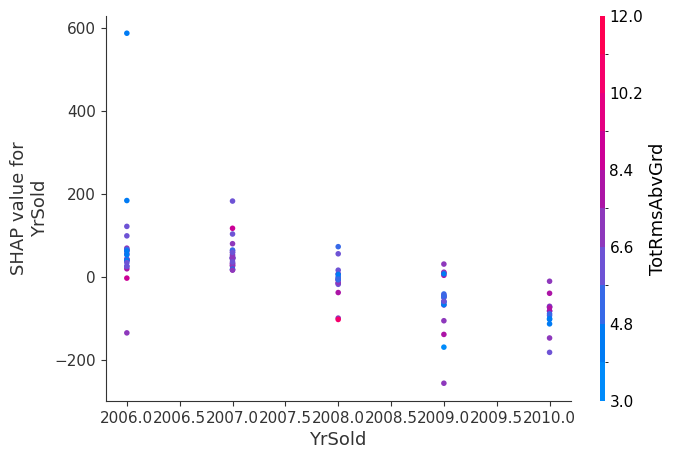

In [16]:
#This loop plots through all of the numerical features and shows the interaction values of each feature. 
for i in range(37):
    shap.dependence_plot(i, shap_values, X_sampled)